# Standardization

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (20, 9)
pd.set_option('display.max_columns', 500)

In [2]:
transactions = pd.read_csv('onlinefraud_with_features.csv')
transactions.head()

,step,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,has_debt,debt,origins_count,min_amount,max_amount,std_amount,median_amount,mean_amount,min_oldbalanceOrg,max_oldbalanceOrg,std_oldbalanceOrg,median_oldbalanceOrg,mean_oldbalanceOrg,min_newbalanceOrig,max_newbalanceOrig,std_newbalanceOrig,median_newbalanceOrig,mean_newbalanceOrig,min_oldbalanceDest,max_oldbalanceDest,std_oldbalanceDest,median_oldbalanceDest,mean_oldbalanceDest,min_newbalanceDest,max_newbalanceDest,std_newbalanceDest,median_newbalanceDest,mean_newbalanceDest,min_step,max_step,std_step,median_step,mean_step,min_has_debt,max_has_debt,std_has_debt,median_has_debt,mean_has_debt,nameDestFirstLetter,amount_has_cents,amount_has_units,amount_has_tens,amount_has_hundreds,amount_is_equal_to_balance,type_code,type=PAYMENT,type=TRANSFER,type=CASH_IN,type=CASH_OUT,nameDestFirstLetter_code,nameDestFirstLetter=M
0,1,9839.64,170136.00,160296.36,M1979787155,0.00,0.00,0,False,-0.00,1,9839.64,9839.64,0.000000,9839.640,9839.640000,170136.0,170136.00,0.000000e+00,170136.0,1.701360e+05,160296.36,160296.36,0.000000e+00,160296.36,1.602964e+05,0.0,0.00,0.000000e+00,0.00,0.000000e+00,0.0,0.00,0.000000e+00,0.00,0.000000e+00,1,1,0.000000,1.0,1.000000,False,False,0.000000,0.0,0.000000,M,True,True,True,True,False,3,True,False,False,False,1,True
1,1,1864.28,21249.00,19384.72,M2044282225,0.00,0.00,0,False,-0.00,1,1864.28,1864.28,0.000000,1864.280,1864.280000,21249.0,21249.00,0.000000e+00,21249.0,2.124900e+04,19384.72,19384.72,0.000000e+00,19384.72,1.938472e+04,0.0,0.00,0.000000e+00,0.00,0.000000e+00,0.0,0.00,0.000000e+00,0.00,0.000000e+00,1,1,0.000000,1.0,1.000000,False,False,0.000000,0.0,0.000000,M,True,True,True,True,False,3,True,False,False,False,1,True
2,1,181.00,181.00,0.00,C553264065,0.00,0.00,1,False,0.00,44,181.00,1447322.21,252655.757617,139366.105,225517.832045,0.0,21782433.66,5.109399e+06,10170.5,1.915190e+06,0.00,22012047.86,5.160588e+06,0.00,1.971241e+06,0.0,4115621.95,1.311491e+06,2820318.13,2.455461e+06,0.0,4115621.95,1.279824e+06,2820318.13,2.534052e+06,1,400,130.627992,41.5,118.954545,False,True,0.461522,1.0,0.704545,C,False,True,True,True,True,4,False,True,False,False,0,False
3,6,109985.65,41851.00,0.00,C553264065,0.00,109985.65,0,True,68134.65,44,181.00,1447322.21,252655.757617,139366.105,225517.832045,0.0,21782433.66,5.109399e+06,10170.5,1.915190e+06,0.00,22012047.86,5.160588e+06,0.00,1.971241e+06,0.0,4115621.95,1.311491e+06,2820318.13,2.455461e+06,0.0,4115621.95,1.279824e+06,2820318.13,2.534052e+06,1,400,130.627992,41.5,118.954545,False,True,0.461522,1.0,0.704545,C,True,True,True,True,False,4,False,True,False,False,0,False
4,7,10256.20,3766080.24,3776336.45,C553264065,109985.65,99729.44,0,False,-0.00,44,181.00,1447322.21,252655.757617,139366.105,225517.832045,0.0,21782433.66,5.109399e+06,10170.5,1.915190e+06,0.00,22012047.86,5.160588e+06,0.00,1.971241e+06,0.0,4115621.95,1.311491e+06,2820318.13,2.455461e+06,0.0,4115621.95,1.279824e+06,2820318.13,2.534052e+06,1,400,130.627992,41.5,118.954545,False,True,0.461522,1.0,0.704545,C,True,True,True,True,False,0,False,False,True,False,0,False


In [3]:
transactions['nameDestFirstLetterIsM'] = transactions['nameDestFirstLetter'] == 'M'
transactions.drop(columns=['nameDestFirstLetter'], inplace=True)

## Split data into train, test and validation sets

In [4]:
train_size = 0.5
test_size = 0.2
validation_size = 0.3
assert train_size + test_size + validation_size == 1

target_column = 'isFraud'
X = transactions.drop(columns=target_column)
y = transactions[target_column]

random_state = 42

datasets = {}

### Common split

In this case we just split data with respect to labels to keep the same positive and negative classes balance in sets.

In [5]:
def add_common_splitted_data(X, y, key='common'):
    X_train, X_remaining, y_train, y_remaining = train_test_split(
        X,
        y,
        train_size=train_size,
        random_state=random_state,
        stratify=y
    )

    X_validation, X_test, y_validation, y_test = train_test_split(
        X_remaining,
        y_remaining,
        test_size=test_size / (test_size + validation_size),
        stratify=y_remaining
    )

    datasets[key] = {
        'X': {
            'train': X_train,
            'test': X_test,
            'validation': X_validation
        },
        'y': {
            'train': y_train,
            'test': y_test,
            'validation': y_validation
        }
    }


add_common_splitted_data(X, y)

### Group split

We use this split to keep all data with the same destination name in one set, to prevent data leak.

In [6]:
round(y.mean(), 5)

0.00129

In [7]:
round(transactions.groupby('nameDest')[target_column].mean().apply(lambda value: int(value * 2) - int(value)).mean(), 5)

0.00126

As we can see, if we group data by nameDest and define class label as label of the major part of the group, we will receive the same balance of classes.

In [8]:
def train_test_split_group(*arrays, **kwargs):
    group_name = kwargs.get('group_name')
    if group_name is None:
        return train_test_split_group(*arrays, **kwargs)
    else:
        del kwargs['group_name']

    X = arrays[0]
    Y = arrays[1]
    data = pd.concat([X, Y], axis=1)
    # define label of group as average of labels of this group, rounded to integer, according to math rules (<0.5 -> 0, >=0.5 -> 1)
    grouped_data = data.groupby(group_name)[target_column].mean().apply(lambda value: int(value * 2) - int(value)).reset_index()
    x = grouped_data[[group_name]]
    y = grouped_data[target_column]
    groups_train, _, _, _ = train_test_split(
        x,
        y,
        stratify=y,
        **kwargs
    )
    train_index = X[group_name].isin(groups_train[group_name].tolist())
    test_index = ~train_index

    X_train = X[train_index]
    y_train = Y[train_index]

    X_test = X[test_index]
    y_test = Y[test_index]

    return X_train, X_test, y_train, y_test

In [9]:
def add_group_splitted_data(X, y, key='group'):
    X_train, X_remaining, y_train, y_remaining = train_test_split_group(X, y, group_name='nameDest', train_size=train_size)
    X_validation, X_test, y_validation, y_test = train_test_split_group(
        X_remaining,
        y_remaining,
        group_name='nameDest',
        test_size=test_size / (test_size + validation_size)
    )

    datasets[key] = {
        'X': {
            'train': X_train,
            'test': X_test,
            'validation': X_validation
        },
        'y': {
            'train': y_train,
            'test': y_test,
            'validation': y_validation
        }
    }
    return X_train, X_test, X_validation, y_train, y_test, y_validation

In [10]:
X_train, X_test, X_validation, y_train, y_test, y_validation = add_group_splitted_data(X, y)

In [11]:
y_train_mean = round(y_train.mean(), 5)
y_test_mean = round(y_test.mean(), 5)
print(f'{y_train_mean=}\t{y_test_mean=}')

y_train_mean=0.0013	y_test_mean=0.00131


In [12]:
pd.merge(
    left=X_train,
    right=X_test,
    on='nameDest'
)

,step_x,amount_x,oldbalanceOrg_x,newbalanceOrig_x,nameDest,oldbalanceDest_x,newbalanceDest_x,has_debt_x,debt_x,origins_count_x,min_amount_x,max_amount_x,std_amount_x,median_amount_x,mean_amount_x,min_oldbalanceOrg_x,max_oldbalanceOrg_x,std_oldbalanceOrg_x,median_oldbalanceOrg_x,mean_oldbalanceOrg_x,min_newbalanceOrig_x,max_newbalanceOrig_x,std_newbalanceOrig_x,median_newbalanceOrig_x,mean_newbalanceOrig_x,min_oldbalanceDest_x,max_oldbalanceDest_x,std_oldbalanceDest_x,median_oldbalanceDest_x,mean_oldbalanceDest_x,min_newbalanceDest_x,max_newbalanceDest_x,std_newbalanceDest_x,median_newbalanceDest_x,mean_newbalanceDest_x,min_step_x,max_step_x,std_step_x,median_step_x,mean_step_x,min_has_debt_x,max_has_debt_x,std_has_debt_x,median_has_debt_x,mean_has_debt_x,amount_has_cents_x,amount_has_units_x,amount_has_tens_x,amount_has_hundreds_x,amount_is_equal_to_balance_x,type_code_x,type=PAYMENT_x,type=TRANSFER_x,type=CASH_IN_x,type=CASH_OUT_x,nameDestFirstLetter_code_x,nameDestFirstLetter=M_x,nameDestFirstLetterIsM_x,step_y,amount_y,oldbalanceOrg_y,newbalanceOrig_y,oldbalanceDest_y,newbalanceDest_y,has_debt_y,debt_y,origins_count_y,min_amount_y,max_amount_y,std_amount_y,median_amount_y,mean_amount_y,min_oldbalanceOrg_y,max_oldbalanceOrg_y,std_oldbalanceOrg_y,median_oldbalanceOrg_y,mean_oldbalanceOrg_y,min_newbalanceOrig_y,max_newbalanceOrig_y,std_newbalanceOrig_y,median_newbalanceOrig_y,mean_newbalanceOrig_y,min_oldbalanceDest_y,max_oldbalanceDest_y,std_oldbalanceDest_y,median_oldbalanceDest_y,mean_oldbalanceDest_y,min_newbalanceDest_y,max_newbalanceDest_y,std_newbalanceDest_y,median_newbalanceDest_y,mean_newbalanceDest_y,min_step_y,max_step_y,std_step_y,median_step_y,mean_step_y,min_has_debt_y,max_has_debt_y,std_has_debt_y,median_has_debt_y,mean_has_debt_y,amount_has_cents_y,amount_has_units_y,amount_has_tens_y,amount_has_hundreds_y,amount_is_equal_to_balance_y,type_code_y,type=PAYMENT_y,type=TRANSFER_y,type=CASH_IN_y,type=CASH_OUT_y,nameDestFirstLetter_code_y,nameDestFirstLetter=M_y,nameDestFirstLetterIsM_y


Our split allowed us to keep the same balance of classes in sets, and also keep all transactions of one recipient in one set to avoid data leek

### Split only types of interest

Not each type of transaction has fraud transactions. Let's simplify data for model and remove types of transactions which doesn't have fraud.

In [13]:
transactions_of_interest = transactions[transactions['type=TRANSFER'] | transactions['type=CASH_OUT']]
X = transactions_of_interest.drop(columns=target_column)
y = transactions_of_interest[target_column]
add_common_splitted_data(X, y, 'common_main_types')
_ = add_group_splitted_data(X, y, 'group_main_types')

In [14]:
datasets.keys()

dict_keys(['common', 'group', 'common_main_types', 'group_main_types'])

In [15]:
for dataset_name, dataset in datasets.items():
    print(dataset_name)
    for set_type in ['train', 'test', 'validation']:
        print()
        print(set_type)
        print(f"{dataset['X'][set_type].shape=}\t{dataset['y'][set_type].shape=}")
    print('\n')

common

train
dataset['X'][set_type].shape=(3181310, 58)	dataset['y'][set_type].shape=(3181310,)

test
dataset['X'][set_type].shape=(1272524, 58)	dataset['y'][set_type].shape=(1272524,)

validation
dataset['X'][set_type].shape=(1908786, 58)	dataset['y'][set_type].shape=(1908786,)


group

train
dataset['X'][set_type].shape=(3182425, 58)	dataset['y'][set_type].shape=(3182425,)

test
dataset['X'][set_type].shape=(1271213, 58)	dataset['y'][set_type].shape=(1271213,)

validation
dataset['X'][set_type].shape=(1908982, 58)	dataset['y'][set_type].shape=(1908982,)


common_main_types

train
dataset['X'][set_type].shape=(1385204, 58)	dataset['y'][set_type].shape=(1385204,)

test
dataset['X'][set_type].shape=(554082, 58)	dataset['y'][set_type].shape=(554082,)

validation
dataset['X'][set_type].shape=(831123, 58)	dataset['y'][set_type].shape=(831123,)


group_main_types

train
dataset['X'][set_type].shape=(1384082, 58)	dataset['y'][set_type].shape=(1384082,)

test
dataset['X'][set_type].shape=(55

### Standardization

In [16]:
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm

columns_to_drop = ['nameDest']
for dataset_name, dataset in tqdm(datasets.items()):
    X = dataset['X']
    y = dataset['y']

    scaler = StandardScaler()

    columns = X['train'].drop(columns=columns_to_drop).columns
    train = scaler.fit_transform(X['train'].drop(columns=columns_to_drop))
    test = scaler.transform(X['test'].drop(columns=columns_to_drop))
    validation = scaler.transform(X['validation'].drop(columns=columns_to_drop))

    X['train'] = pd.DataFrame(train, columns=columns)
    X['test'] = pd.DataFrame(test, columns=columns)
    X['validation'] = pd.DataFrame(validation, columns=columns)

    del train
    del test
    del validation

    for key, value in tqdm(X.items()):
        dir_name = 'data'
        if not os.path.isdir(dir_name):
            os.mkdir(dir_name)
        value.to_csv(f'./{dir_name}/x_{dataset_name}_{key}.csv', index=False)
        y[key].to_csv(f'./{dir_name}/y_{dataset_name}_{key}.csv', index=False)

100%|██████████| 4/4 [17:44<00:00, 266.08s/it]


In [17]:
data = datasets['group_main_types']
X = data['X']
y = data['y']

X_train, X_test, X_validation = X['train'], X['test'], X['validation']
y_train, y_test, y_validation = y['train'], y['test'], y['validation']

del datasets
del transactions

# Dimensionality reduction

Let's reduce number of dimensions to achieve better results

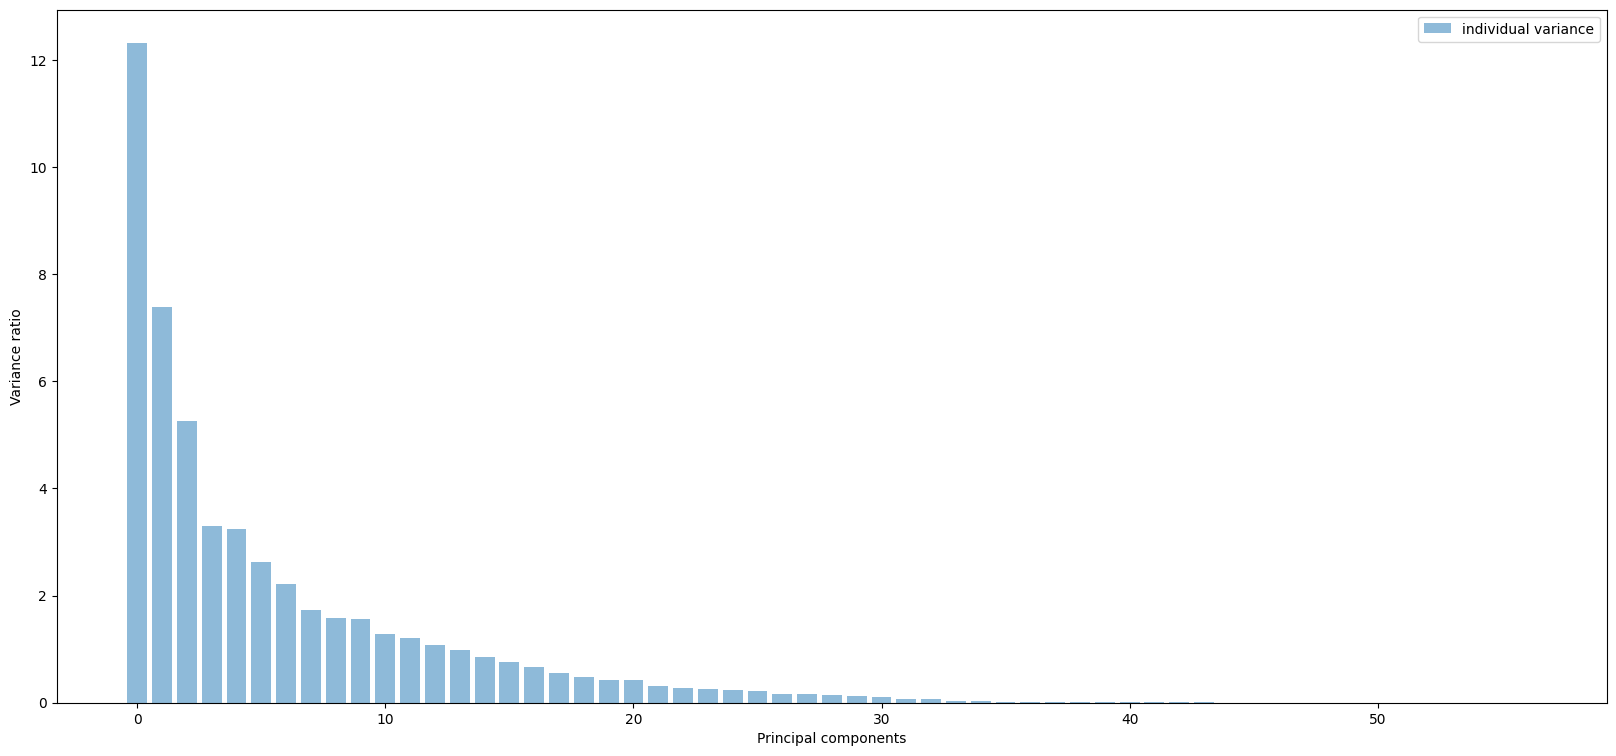

In [21]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit_transform(X_validation)
pca_variance = pca.explained_variance_

plt.bar(range(X_validation.shape[1]), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

As we can see, about 20 features are the most informative according to PCA. But we want to keep data easy to interpret, so let's choose other methods for dimensionality reduciton.

Let's train some model with high predictive ability and choose the most important variables.

In [41]:
from catboost import CatBoostClassifier
import numpy as np


def rounded_accuracy_score(*args, n_digits=6, **kwargs):
    if 'n_digits' in kwargs:
        del kwargs['n_digits']
    return round(accuracy_score(*args, **kwargs), n_digits)


model = CatBoostClassifier()
model.fit(X_train, y_train)

y_pred_catboost = model.predict(X_validation)
stupid_y_pred = np.zeros_like(y_validation)

accuracy = rounded_accuracy_score(
    y_true=y_validation,
    y_pred=y_pred_catboost
)
baseline_accuracy = rounded_accuracy_score(
    y_true=y_validation,
    y_pred=stupid_y_pred
)

print(f'{accuracy=}, {baseline_accuracy=}')

accuracy=0.99999, baseline_accuracy=0.996963


In [29]:
y_pred_prob = model.predict_proba(X_validation)

As we can see, our model has very high accuracy, but it is not very informative, because baseline model which predict always false label demonstrates also very high accuracy. Let's try other metrics to deal with unbalanced classes.

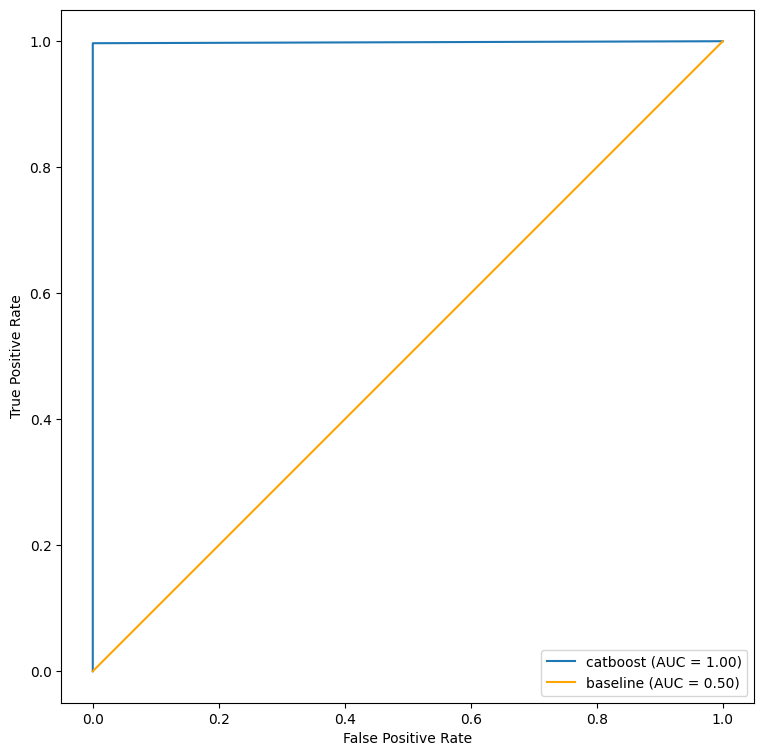

In [40]:
from sklearn.metrics import RocCurveDisplay, accuracy_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix

ax = plt.axes()
RocCurveDisplay.from_predictions(
    y_true=y_validation,
    y_pred=y_pred_catboost,
    name='catboost',
    ax=ax
)

RocCurveDisplay.from_predictions(
    y_true=y_validation,
    y_pred=stupid_y_pred,
    name='baseline',
    color='orange',
    ax=ax
)

# plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [46]:
rounder = lambda value, digits=5: round(value, digits)
for metric_score in [accuracy_score, precision_score, recall_score, matthews_corrcoef]:
    print(f'{metric_score.__name__}:')
    for y_pred, model_name in zip([y_pred_catboost, stupid_y_pred], ['catboost', 'always_negative_model']):
        metric_value = metric_score(
            y_true=y_validation,
            y_pred=y_pred
        )
        metric_value = rounder(metric_value)
        print(f'\t{model_name}: {metric_value}')


accuracy_score:
	catboost: 0.99999
	always_negative_model: 0.99696
precision_score:
	catboost: 1.0
	always_negative_model: 0.0
recall_score:


/home/demidov-artem/PycharmProjects/CVTDM_Fraud_Prediction/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	catboost: 0.99683
	always_negative_model: 0.0
matthews_corrcoef:
	catboost: 0.99841
	always_negative_model: 0.0


As we can see, all metrics, except accuracy, allowed to beat baseline model and demonstrate it's failure

In [55]:
from IPython.display import display

print('confusion matrix:')
for y_pred, model_name in zip([y_pred_catboost, stupid_y_pred], ['catboost', 'always_negative_model']):
    metric_value = confusion_matrix(
        y_true=y_validation,
        y_pred=y_pred
    )
    print(f'\t{model_name}')
    display(metric_value)
    display(np.round(metric_value/np.trace(metric_value), 6))

confusion matrix:
	catboost


array([[827905,      0],
       [     8,   2514]])

array([[9.96973e-01, 0.00000e+00],
       [1.00000e-05, 3.02700e-03]])

	always_negative_model


array([[827905,      0],
       [  2522,      0]])

array([[1.      , 0.      ],
       [0.003046, 0.      ]])

In [66]:
def get_importance_table(used_features=None):
    if used_features is None:
        used_features = X_validation.columns
    importance = pd.DataFrame(model.get_feature_importance(), columns=['importance'])
    importance['columns'] = used_features
    importance = importance.sort_values(by='importance', ascending=False).reset_index(drop=True)
    return importance


In [61]:
importance = get_importance_table()
importance

,importance,columns
0,15.650794,step
1,7.906781,oldbalanceOrg
2,6.484236,amount_is_equal_to_balance
3,5.339662,newbalanceDest
4,5.214445,oldbalanceDest
5,4.661854,std_oldbalanceOrg
6,4.355724,max_oldbalanceOrg
7,3.734070,debt
8,3.587980,amount
9,2.779926,mean_newbalanceOrig


In [62]:
top_features = importance.head(20)['columns'].tolist()

In [63]:
model.fit(X_train[top_features], y_train)

y_pred_catboost = model.predict(X_validation[top_features])
stupid_y_pred = np.zeros_like(y_validation)

accuracy = rounded_accuracy_score(
    y_true=y_validation,
    y_pred=y_pred_catboost
)
baseline_accuracy = rounded_accuracy_score(
    y_true=y_validation,
    y_pred=stupid_y_pred
)

print(f'{accuracy=}, {baseline_accuracy=}')

Learning rate set to 0.226053
0:	learn: 0.0971026	total: 187ms	remaining: 3m 6s
1:	learn: 0.0150712	total: 294ms	remaining: 2m 26s
2:	learn: 0.0032754	total: 374ms	remaining: 2m 4s
3:	learn: 0.0010481	total: 467ms	remaining: 1m 56s
4:	learn: 0.0004765	total: 557ms	remaining: 1m 50s
5:	learn: 0.0002927	total: 645ms	remaining: 1m 46s
6:	learn: 0.0002212	total: 738ms	remaining: 1m 44s
7:	learn: 0.0001890	total: 828ms	remaining: 1m 42s
8:	learn: 0.0001718	total: 916ms	remaining: 1m 40s
9:	learn: 0.0001649	total: 1.02s	remaining: 1m 40s
10:	learn: 0.0001591	total: 1.11s	remaining: 1m 39s
11:	learn: 0.0001556	total: 1.2s	remaining: 1m 38s
12:	learn: 0.0001546	total: 1.29s	remaining: 1m 38s
13:	learn: 0.0001529	total: 1.38s	remaining: 1m 37s
14:	learn: 0.0001525	total: 1.47s	remaining: 1m 36s
15:	learn: 0.0001516	total: 1.56s	remaining: 1m 36s
16:	learn: 0.0001513	total: 1.65s	remaining: 1m 35s
17:	learn: 0.0001505	total: 1.72s	remaining: 1m 34s
18:	learn: 0.0001491	total: 1.82s	remaining: 1m

As we can see, our model kept the same accuracy.

In [67]:
importance = get_importance_table(top_features)
importance

,importance,columns
0,10.115498,step
1,8.548715,oldbalanceOrg
2,7.887570,oldbalanceDest
3,6.966856,newbalanceDest
4,6.626446,std_oldbalanceDest
5,6.299706,std_oldbalanceOrg
6,6.116315,std_amount
7,5.947774,amount_is_equal_to_balance
8,4.911319,min_amount
9,4.712226,debt


Let's choose top-10 most important features and try test model again

In [68]:
top_10_features = top_features = importance.head(10)['columns'].tolist()

In [69]:
model.fit(X_train[top_10_features], y_train)

y_pred_catboost = model.predict(X_validation[top_10_features])
stupid_y_pred = np.zeros_like(y_validation)

accuracy = rounded_accuracy_score(
    y_true=y_validation,
    y_pred=y_pred_catboost
)
baseline_accuracy = rounded_accuracy_score(
    y_true=y_validation,
    y_pred=stupid_y_pred
)

print(f'{accuracy=}, {baseline_accuracy=}')

Learning rate set to 0.226053
0:	learn: 0.1080987	total: 168ms	remaining: 2m 47s
1:	learn: 0.0172573	total: 280ms	remaining: 2m 19s
2:	learn: 0.0034701	total: 376ms	remaining: 2m 4s
3:	learn: 0.0011198	total: 480ms	remaining: 1m 59s
4:	learn: 0.0004882	total: 583ms	remaining: 1m 56s
5:	learn: 0.0002931	total: 695ms	remaining: 1m 55s
6:	learn: 0.0002174	total: 806ms	remaining: 1m 54s
7:	learn: 0.0001846	total: 917ms	remaining: 1m 53s
8:	learn: 0.0001672	total: 1.02s	remaining: 1m 52s
9:	learn: 0.0001583	total: 1.14s	remaining: 1m 52s
10:	learn: 0.0001531	total: 1.26s	remaining: 1m 53s
11:	learn: 0.0001501	total: 1.34s	remaining: 1m 50s
12:	learn: 0.0001471	total: 1.42s	remaining: 1m 47s
13:	learn: 0.0001460	total: 1.5s	remaining: 1m 45s
14:	learn: 0.0001439	total: 1.58s	remaining: 1m 43s
15:	learn: 0.0001426	total: 1.67s	remaining: 1m 42s
16:	learn: 0.0001418	total: 1.77s	remaining: 1m 42s
17:	learn: 0.0001414	total: 1.87s	remaining: 1m 41s
18:	learn: 0.0001409	total: 1.97s	remaining: 1

Accuracy is still very high, let's remove values one by one and check results.